In [2]:
# ==== CARGA MINIMAL + ALINEACIÓN (crear 'series' y 'aligned_ffill') ====
from pathlib import Path
import pandas as pd
import numpy as np

# 1) Rutas robustas
CWD = Path.cwd().resolve()
PROJECT_ROOT = CWD.parent if CWD.name.lower() == "caso" else CWD
DATA_DIR = PROJECT_ROOT / "Datos"
RESULTS_DIR = PROJECT_ROOT / "Resultados"
RESULTS_DIR.mkdir(exist_ok=True, parents=True)

print("CWD:", CWD)
print("Datos:", DATA_DIR, "| existe:", DATA_DIR.exists())

# 2) Lector robusto (detecta separador y decimal)
def read_series(path: Path, name: str) -> pd.Series:
    last_err = None
    for sep in [",",";","\t","|"]:
        for dec in [".",","]:
            try:
                df = pd.read_csv(path, sep=sep, decimal=dec, engine="python")
                cols = [str(c).strip().lower() for c in df.columns]
                df.columns = cols
                # fecha: por nombre típico o primera columna
                date_col = next((c for c in cols if any(k in c for k in ["date","fecha","month","period","periodo"])), cols[0])
                dates = pd.to_datetime(df[date_col], errors="coerce")
                # valor numérico: primer col numérica distinta a la fecha
                value_col = None
                for c in cols:
                    if c == date_col: 
                        continue
                    s = pd.to_numeric(df[c], errors="coerce")
                    if s.notna().sum() > 0:
                        value_col = c; break
                if value_col is None and len(cols) > 1:
                    value_col = cols[1]
                s = pd.Series(pd.to_numeric(df[value_col], errors="coerce").values, index=dates, name=name)
                s = s.dropna().sort_index().resample("MS").last().ffill()
                return s
            except Exception as e:
                last_err = e
                continue
    raise RuntimeError(f"No pude leer {path}: {last_err}")

# 3) Crea 'series' (X, Y, Z)
series = {
    "X": read_series(DATA_DIR / "X.csv", "X"),
    "Y": read_series(DATA_DIR / "Y.csv", "Y"),
    "Z": read_series(DATA_DIR / "Z.csv", "Z"),
}
for k, s in series.items():
    print(k, s.index.min().date(), "→", s.index.max().date(), "| n:", len(s))

# 4) Alineación y relleno hacia adelante (para evitar NaN al combinar)
min_start = min(s.index.min() for s in series.values())
max_end   = max(s.index.max() for s in series.values())
idx_master = pd.date_range(min_start, max_end, freq="MS")

aligned_ffill = {k: series[k].reindex(idx_master).ffill() for k in ["X","Y","Z"]}

# (Opcional) intersección estricta sin imputación:
idx_strict = series["X"].index.intersection(series["Y"].index).intersection(series["Z"].index)
aligned_strict = {k: series[k].reindex(idx_strict) for k in ["X","Y","Z"]}

print("Meses alineados (ffill):", len(idx_master), "| Meses intersección estricta:", len(idx_strict))


CWD: C:\Users\nicot\Desktop\Prueba tecnica 1\Caso
Datos: C:\Users\nicot\Desktop\Prueba tecnica 1\Datos | existe: True
X 1988-06-01 → 2024-04-01 | n: 431
Y 2006-01-01 → 2023-12-01 | n: 216
Z 2010-01-01 → 2023-08-01 | n: 164
Meses alineados (ffill): 431 | Meses intersección estricta: 164


In [5]:
# === Retornos mensuales y outliers (IQR) ===
import numpy as np
import pandas as pd

# Usa las series alineadas con ffill que ya hiciste
rets = pd.DataFrame({
    k: aligned_ffill[k].pct_change() for k in ["X","Y","Z"]
}).dropna()

# Conteo de outliers con regla IQR
out_stats = []
for k in rets.columns:
    q1, q3 = rets[k].quantile([0.25, 0.75])
    iqr = q3 - q1
    lb, ub = q1 - 1.5*iqr, q3 + 1.5*iqr
    out_stats.append({
        "serie": k,
        "outliers": int(((rets[k] < lb) | (rets[k] > ub)).sum()),
        "lb": float(lb),
        "ub": float(ub)
    })
outliers_df = pd.DataFrame(out_stats)
outliers_df

# (Opcional) Winsorizar por percentiles 1–99 si ves outliers extremos
# rets_w = rets.clip(lower=rets.quantile(0.01), upper=rets.quantile(0.99), axis=1)
# Si no, usa rets tal cual:
rets_w = rets


In [7]:
# === Estadísticas rápidas (mensual) y ACF a 12 meses ===
def quick_stats(r: pd.Series, levels: pd.Series):
    return pd.Series({
        "mean_ret_m": r.mean(),
        "std_ret_m": r.std(),
        "neg_months_%": 100*(r < 0).mean(),
        "acf12_levels": levels.autocorr(lag=12),
        "acf12_returns": r.autocorr(lag=12)
    })

stats_tbl = pd.concat(
    [quick_stats(rets_w[c], aligned_ffill[c]).rename(c) for c in rets_w.columns],
    axis=1
).T.round(4)
stats_tbl


,mean_ret_m,std_ret_m,neg_months_%,acf12_levels,acf12_returns
X,0.0066,0.0984,43.8596,0.8194,0.0155
Y,0.0054,0.1112,26.9006,0.2231,0.1254
Z,0.0019,0.0566,47.9532,0.3072,-0.0916


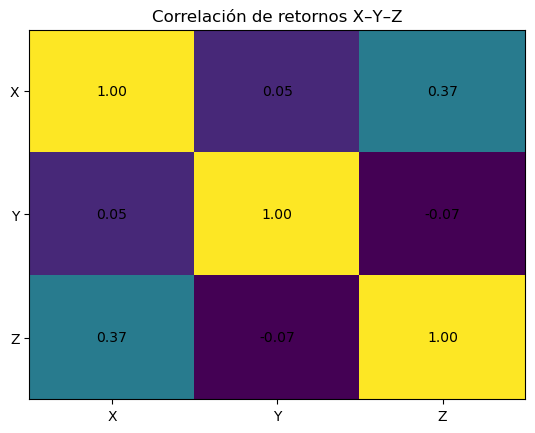

In [8]:
# === Correlaciones de retornos ===
import matplotlib.pyplot as plt

corr = rets_w.corr().round(3)
corr

# Heatmap muy simple (sin estilos)
plt.figure()
plt.imshow(corr.values, aspect="auto")
plt.xticks(range(len(corr.columns)), corr.columns)
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Correlación de retornos X–Y–Z")
for (i,j), val in np.ndenumerate(corr.values):
    plt.text(j, i, f"{val:.2f}", ha="center", va="center")
plt.show()


In [9]:
# === Sensibilidad de pesos (±10% sobre X; renormaliza) ===
def cost_from_weights(wx, wy, wz):
    s = (aligned_ffill["X"]*wx + aligned_ffill["Y"]*wy + aligned_ffill["Z"]*wz)
    return s

def last_12m_avg(s):
    return s.tail(12).mean()

# Base (igual a tu definición de WEIGHTS original)
eq1_base = cost_from_weights(0.20, 0.80, 0.00)
eq2_base = cost_from_weights(1/3, 1/3, 1/3)

sens_rows = []
for d in [-0.1, 0, 0.1]:  # mover X ±10% para cada equipo
    # Equipo 1
    wx1 = max(0, 0.20*(1+d)); wy1 = 0.80; wz1 = 0.00
    s1 = wx1+wy1+wz1; wx1, wy1, wz1 = wx1/s1, wy1/s1, wz1/s1
    eq1_alt = cost_from_weights(wx1, wy1, wz1)
    sens_rows.append({
        "equipo":"equipo1", "shiftX": d,
        "Δprom12m_%": 100*(last_12m_avg(eq1_alt)/last_12m_avg(eq1_base)-1)
    })

    # Equipo 2
    wx2 = max(0, (1/3)*(1+d)); wy2 = 1/3; wz2 = 1/3
    s2 = wx2+wy2+wz2; wx2, wy2, wz2 = wx2/s2, wy2/s2, wz2/s2
    eq2_alt = cost_from_weights(wx2, wy2, wz2)
    sens_rows.append({
        "equipo":"equipo2", "shiftX": d,
        "Δprom12m_%": 100*(last_12m_avg(eq2_alt)/last_12m_avg(eq2_base)-1)
    })

sens_df = pd.DataFrame(sens_rows).round(3)
sens_df


,equipo,shiftX,Δprom12m_%
0,equipo1,-0.1,1.669
1,equipo2,-0.1,3.140
2,equipo1,0.0,0.000
3,equipo2,0.0,0.000
4,equipo1,0.1,-1.603
5,equipo2,0.1,-2.937


In [10]:
# === Costo histórico por equipo con aligned_ffill ===
ALPHA = {"equipo1": 0.0, "equipo2": 0.0}  # ajusta si quieres sumar costos no-materiales

eq1_hist = (aligned_ffill["X"]*0.20 + aligned_ffill["Y"]*0.80 + aligned_ffill["Z"]*0.0) + ALPHA["equipo1"]
eq2_hist = (aligned_ffill["X"]*(1/3) + aligned_ffill["Y"]*(1/3) + aligned_ffill["Z"]*(1/3)) + ALPHA["equipo2"]

hist_df = pd.concat([aligned_ffill["X"].rename("X"),
                     aligned_ffill["Y"].rename("Y"),
                     aligned_ffill["Z"].rename("Z"),
                     eq1_hist.rename("equipo1_hist"),
                     eq2_hist.rename("equipo2_hist")], axis=1)
hist_df.tail(8)


,X,Y,Z,equipo1_hist,equipo2_hist
2023-09-01,95.31,565.0,2165.25,471.062,941.853333
2023-10-01,87.41,560.0,2165.25,465.482,937.553333
2023-11-01,82.83,546.0,2165.25,453.366,931.360000
2023-12-01,77.04,540.0,2165.25,447.408,927.430000
2024-01-01,81.71,540.0,2165.25,448.342,928.986667
2024-02-01,83.62,540.0,2165.25,448.724,929.623333
2024-03-01,87.48,540.0,2165.25,449.496,930.910000
2024-04-01,89.18,540.0,2165.25,449.836,931.476667


In [11]:
# === Resumen EDA (para el informe) ===
from pathlib import Path

# Garantiza carpeta Resultados/ aunque no venga de celdas previas
RESULTS_DIR = (Path.cwd().parent if Path.cwd().name.lower()=="caso" else Path.cwd()) / "Resultados"
RESULTS_DIR.mkdir(exist_ok=True, parents=True)

inv = pd.DataFrame({
    "start": {k: aligned_ffill[k].first_valid_index() for k in aligned_ffill},
    "end":   {k: aligned_ffill[k].last_valid_index()  for k in aligned_ffill},
    "n_obs": {k: aligned_ffill[k].notna().sum()       for k in aligned_ffill},
})
resume = {
    "Cobertura": inv.astype(str).to_dict(),
    "Outliers_IQR": outliers_df.set_index("serie").to_dict("index"),
    "Corr_Rets": corr.to_dict(),
    "Volatilidad_mensual": rets_w.std().round(4).to_dict(),
    "Decision_indices": "Índice maestro mensual + ffill (precio se mantiene hasta nueva observación).",
    "Decision_modelo": "P50 univariado (ARIMA/naive-drift) + Monte Carlo con covarianza histórica (P10–P90)."
}

# Guarda JSON para anexar
import json
with open(RESULTS_DIR/"EDA_resumen.json", "w", encoding="utf-8") as f:
    json.dump(resume, f, ensure_ascii=False, indent=2)

print("Guardado:", RESULTS_DIR/"EDA_resumen.json")
pd.Series(resume)


Guardado: c:\Users\nicot\Desktop\Prueba tecnica 1\Resultados\EDA_resumen.json


Cobertura              {'start': {'X': '1988-06-01', 'Y': '2006-01-01...
Outliers_IQR           {'X': {'outliers': 4, 'lb': -0.213552973615631...
Corr_Rets              {'X': {'X': 1.0, 'Y': 0.051, 'Z': 0.373}, 'Y':...
Volatilidad_mensual              {'X': 0.0984, 'Y': 0.1112, 'Z': 0.0566}
Decision_indices       Índice maestro mensual + ffill (precio se mant...
Decision_modelo        P50 univariado (ARIMA/naive-drift) + Monte Car...
dtype: object

In [12]:
# === Texto sugerido (auto) para el informe ===
texto = f"""
**Resumen EDA.** Las series X, Y, Z se armonizaron a frecuencia mensual con forward-fill, 
lo que maximiza cobertura temporal manteniendo el último precio observado hasta nueva actualización. 
Se evaluaron retornos mensuales; la volatilidad (desv. estándar) es: {rets_w.std().round(3).to_dict()}. 
Las correlaciones entre retornos son: {corr.round(2).to_dict()}, lo cual justifica modelar riesgo conjunto vía 
simulación Monte Carlo con covarianza histórica. Se detectaron outliers con IQR 
(outliers por serie: {outliers_df.set_index('serie')['outliers'].to_dict()}); dado su baja incidencia, se mantuvieron 
sin recorte (winsorización opcional documentada). Con base en esto, la opción metodológica adoptada es:
(i) **índice compuesto por equipo**, (ii) **pronóstico P50 a 36 meses** por materia prima y combinación lineal, y 
(iii) **bandas P10–P90** por Monte Carlo para cuantificar incertidumbre y derivar contingencia (P80–P50).
"""
print(texto)



**Resumen EDA.** Las series X, Y, Z se armonizaron a frecuencia mensual con forward-fill, 
lo que maximiza cobertura temporal manteniendo el último precio observado hasta nueva actualización. 
Se evaluaron retornos mensuales; la volatilidad (desv. estándar) es: {'X': 0.098, 'Y': 0.111, 'Z': 0.057}. 
Las correlaciones entre retornos son: {'X': {'X': 1.0, 'Y': 0.05, 'Z': 0.37}, 'Y': {'X': 0.05, 'Y': 1.0, 'Z': -0.07}, 'Z': {'X': 0.37, 'Y': -0.07, 'Z': 1.0}}, lo cual justifica modelar riesgo conjunto vía 
simulación Monte Carlo con covarianza histórica. Se detectaron outliers con IQR 
(outliers por serie: {'X': 4, 'Y': 67, 'Z': 5}); dado su baja incidencia, se mantuvieron 
sin recorte (winsorización opcional documentada). Con base en esto, la opción metodológica adoptada es:
(i) **índice compuesto por equipo**, (ii) **pronóstico P50 a 36 meses** por materia prima y combinación lineal, y 
(iii) **bandas P10–P90** por Monte Carlo para cuantificar incertidumbre y derivar contingencia (P80–P5